In [1]:
# import glob # For getting file names
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# import pandas as pd
# import pickle
# # import seaborn as sns
# # import torch

# from collections import Counter
# # from gap_statistic import OptimalK
# from scipy import stats, cluster
# from sklearn.cluster import KMeans
# # from yellowbrick.cluster import KElbowVisualizer

# from utils.clustering_utils import *
# from utils.conformal_utils import *
from utils.experiment_utils import *

%load_ext autoreload
%autoreload 2

In [2]:
sns.set_style(style='white', rc={'axes.spines.right': False, 'axes.spines.top': False})
sns.set_palette('pastel')
sns.set_context('paper') # 'paper', 'talk', 'poster'

In [3]:
# For square-root scale 
import matplotlib.scale as mscale
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker
import numpy as np

class SquareRootScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square root scale.
    """
 
    name = 'squareroot'
 
    def __init__(self, axis, **kwargs):
        # note in older versions of matplotlib (<3.1), this worked fine.
        # mscale.ScaleBase.__init__(self)

        # In newer versions (>=3.1), you also need to pass in `axis` as an arg
        mscale.ScaleBase.__init__(self, axis)
 
    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())
 
    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax
 
    class SquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform_non_affine(self, a): 
            return np.array(a)**0.5
 
        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()
 
    class InvertedSquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform(self, a):
            return np.array(a)**2
 
        def inverted(self):
            return SquareRootScale.SquareRootTransform()
 
    def get_transform(self):
        return self.SquareRootTransform()
 
mscale.register_scale(SquareRootScale)

# fig, ax = plt.subplots(1)

# ax.plot(np.arange(0, 9)**2, label='$y=x^2$')
# ax.legend()

# ax.set_xscale('squareroot')
# ax.set_yticks(np.arange(0,9,2)**2)
# ax.set_yticks(np.arange(0,8.5,0.5)**2, minor=True)

# plt.show()



In [4]:
save_folder = '.cache/paper/varying_n'
dataset_list = ['imagenet', 'cifar-100', 'places365', 'inaturalist']
cal_sampling_list = ['random']
score_function_list = ['softmax', 'APS', 'RAPS']
method_list = ['standard', 'classwise',
               'cluster_proportional', 'cluster_random']
n_list = [10, 20, 30, 40, 50, 75, 100, 150]
expected_num_seeds = 10

In [5]:
# Helper function to check which results are missing
def check_for_missing_results(save_folder, dataset_list, cal_sampling_list, 
                              n_list, score_function_list, method_list,
                              expected_num_seeds=10):
    '''
    Check if results exist for all combinations of settings
    '''
    for dataset in dataset_list:
        for cal_sampling in cal_sampling_list:
            for n_totalcal in n_list: 
                for score_function in score_function_list:
                    for seed in range(expected_num_seeds):
                        pth = os.path.join(save_folder,
                                           f'{dataset}/{cal_sampling}_calset/n_totalcal={n_totalcal}/score={score_function}/seed={seed}_allresults.pkl')
                    
                        try:
                            with open(pth, 'rb') as f:
                                results = pickle.load(f)
                                
                            for method in method_list:
                                if method not in results.keys():
                                    print(f'{method} is missing in {pth}')
                        except:
                            print(f'Missing file {pth}')
                                
check_for_missing_results(save_folder, dataset_list, cal_sampling_list, 
                              n_list, score_function_list, method_list,
                              expected_num_seeds=10)

In [6]:
def initialize_dict(metrics, methods, suffixes=['mean', 'se']):
    d = {}
    for suffix in suffixes: 
        for metric in metrics:
            d[f'{metric}_{suffix}'] = {}

            for method in methods:

                d[f'{metric}_{suffix}'][method] = []
            
            
    return d

def make_varying_n_plot(dataset, score_function, 
                        n_list = [10, 20, 30, 40, 50, 75, 100], 
                        save_folder='.cache/paper/varying_n',
                        metric_list = ['class_cov_gap', 'avg_set_size'],
                        cal_sampling = 'random',
                        metric_to_name = {'class_cov_gap': 'CovGap', 'avg_set_size': 'AvgSize', 'very_undercovered': 'Fraction very undercovered'},
                        method_list = ['standard', 'classwise', 'classwise_default_standard', 'cluster_balanced'],
                        dataset_to_name = {'imagenet': 'ImageNet', 'cifar-100': 'CIFAR-100', 
                       'places365': 'Places365', 'inaturalist': 'iNaturalist'}): 

    # 1) Compute aggregated_results dict
    aggregated_results = initialize_dict(metric_list, method_list)

    for n_totalcal in n_list:

        curr_folder = f'{save_folder}/{dataset}/{cal_sampling}_calset/n_totalcal={n_totalcal}/score={score_function}'

        print(curr_folder)
        df = average_results_across_seeds(curr_folder, print_results=False, 
                                          display_table=False, methods=method_list, max_seeds=10) # Only use at most 10 seeds

#         display(df)
        for metric in metric_list:

            for method in method_list:

                for suffix in ['mean', 'se']: # Extract mean and SE

                    aggregated_results[f'{metric}_{suffix}'][method].append(df[f'{metric}_{suffix}'][df['method']==method].values[0])
    
    # 2) Make plot 
    for metric in metric_list:

            for method in method_list:
                x = n_list
                y = np.array(aggregated_results[f'{metric}_mean'][method])
                se = np.array(aggregated_results[f'{metric}_se'][method])
                plt.plot(x, y, '-o', label=method, alpha=1)
                # Add 95% error bars
                plt.fill_between(x, y-1.96*se, y+1.96*se, alpha=0.4)

            plt.xlabel('Average number of examples per class')
            plt.ylabel(metric_to_name[metric])
            plt.title(f'{dataset_to_name[dataset]}, {score_function} ({cal_sampling} calibration set)')
            plt.legend()
            if metric == 'class_cov_gap':
                plt.ylim(1,9)
            if metric == 'avg_set_size':
                plt.ylim(0,20)
                
            plt.xscale('squareroot')
            plt.xlim(left=8)
            
            plt.xticks(n_list)
            plt.show()


In [7]:
# n_list = [10, 20, 30, 40, 50, 75, 100]
n_list = [10, 20, 30, 40, 50, 75, 100, 150]

save_folder = '.cache/paper/varying_n/'
cal_sampling = 'random' # 'random' or 'balanced'

metric_list = ['class_cov_gap', 'avg_set_size', 'very_undercovered']
# metric_list = ['class_cov_gap']
# metric_list = ['class_cov_gap', 'very_undercovered']

# method_list = ['standard', 'classwise', 'classwise_default_standard', 
#                'cluster_balanced', 'cluster_proportional', 'cluster_doubledip', 
#                'regularized_classwise']
# method_list = ['standard', 'classwise',
#                'cluster_proportional',  
#                'regularized_classwise']
method_list = ['standard', 'classwise',
               'cluster_proportional', 'cluster_random']

.cache/paper/varying_n/imagenet/random_calset/n_totalcal=10/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=20/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=30/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=40/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=50/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=75/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=100/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=150/score=softmax
Number of seeds found: 10


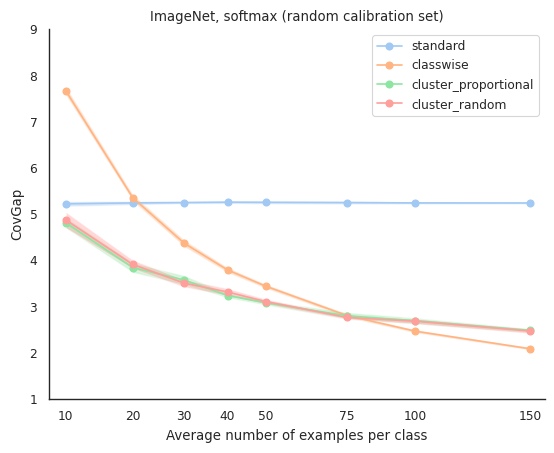

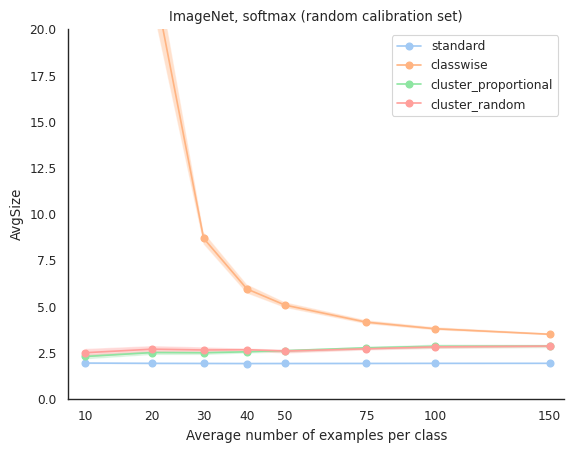

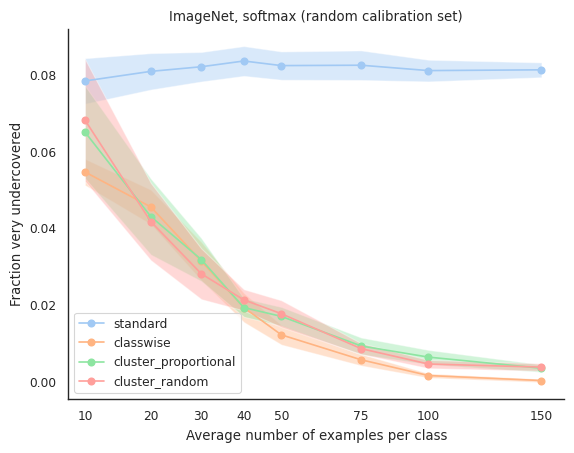

.cache/paper/varying_n/imagenet/random_calset/n_totalcal=10/score=APS
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=20/score=APS
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=30/score=APS
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=40/score=APS
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=50/score=APS
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=75/score=APS
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=100/score=APS
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=150/score=APS
Number of seeds found: 10


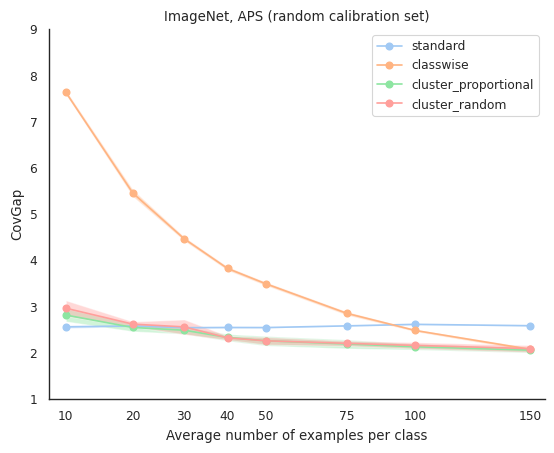

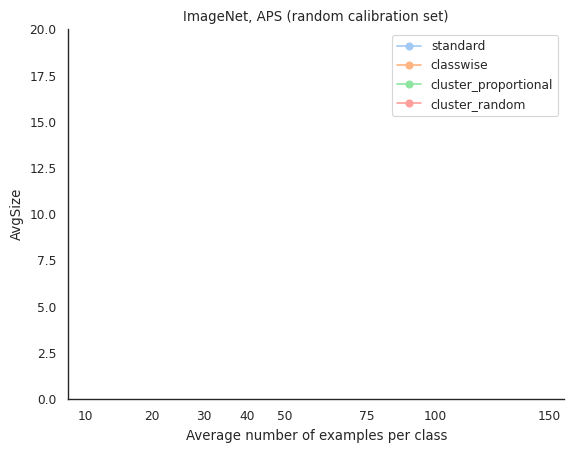

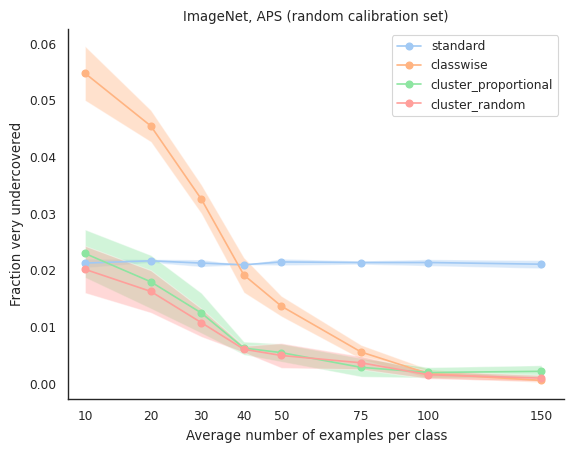

.cache/paper/varying_n/imagenet/random_calset/n_totalcal=10/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=20/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=30/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=40/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=50/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=75/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=100/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/imagenet/random_calset/n_totalcal=150/score=RAPS
Number of seeds found: 10


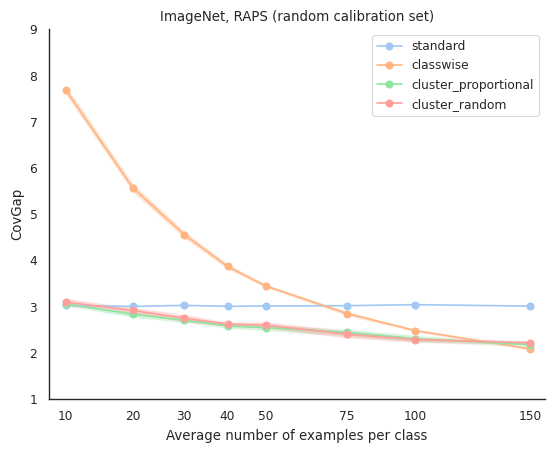

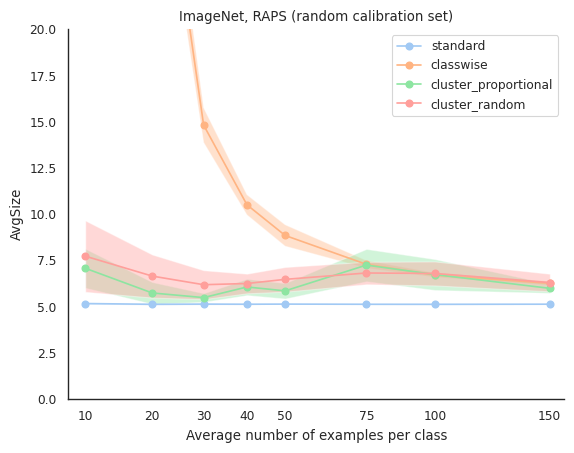

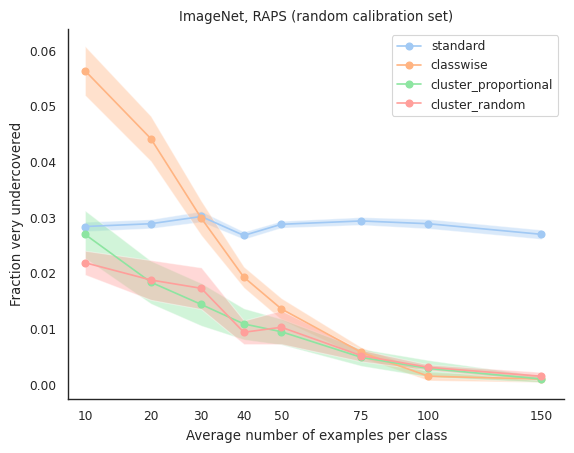

.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=10/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=20/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=30/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=40/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=50/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=75/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=100/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=150/score=softmax
Number of seeds found: 10


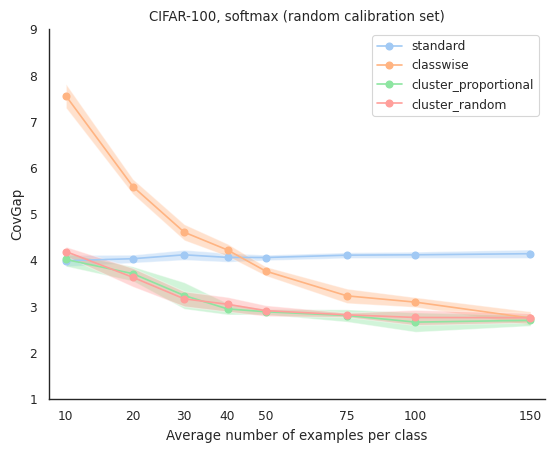

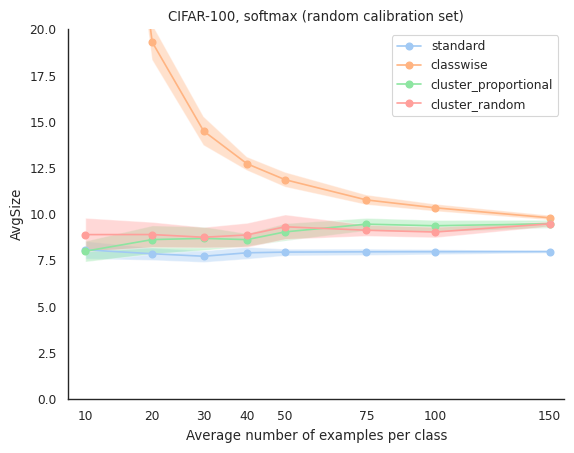

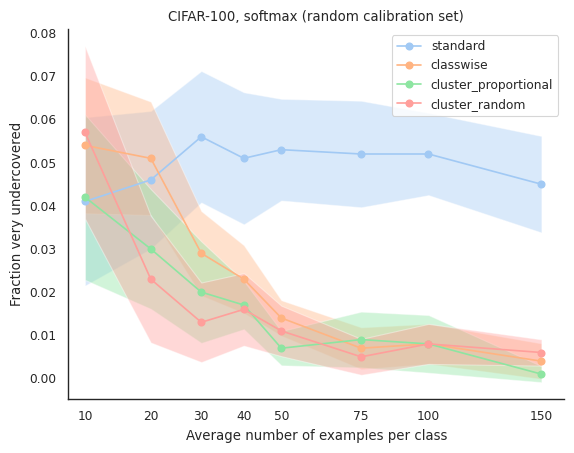

.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=10/score=APS
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=20/score=APS
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=30/score=APS
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=40/score=APS
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=50/score=APS
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=75/score=APS
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=100/score=APS
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=150/score=APS
Number of seeds found: 10


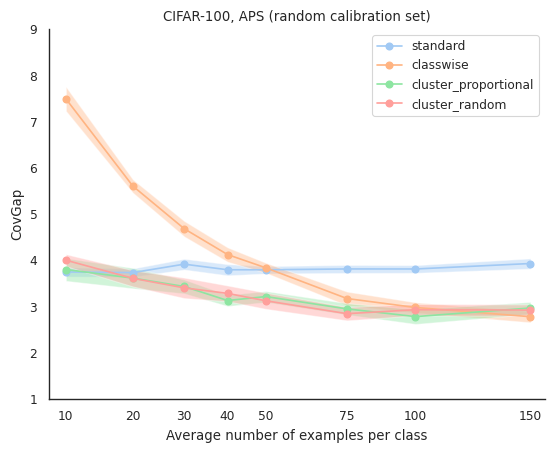

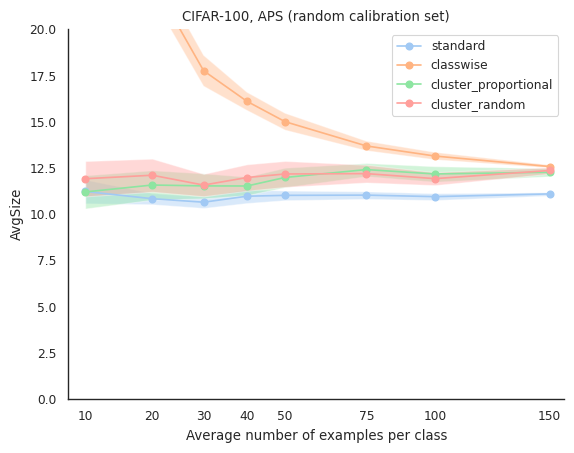

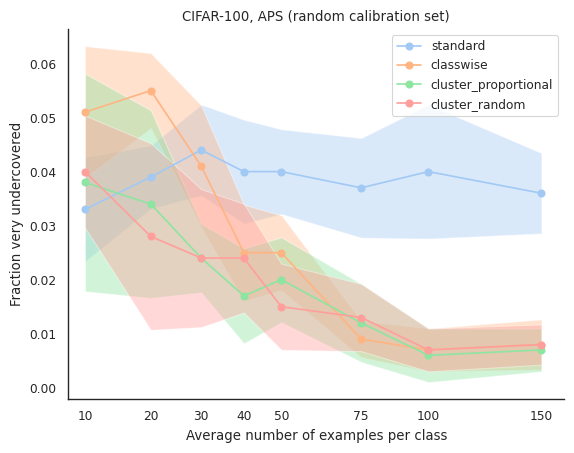

.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=10/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=20/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=30/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=40/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=50/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=75/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=100/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/cifar-100/random_calset/n_totalcal=150/score=RAPS
Number of seeds found: 10


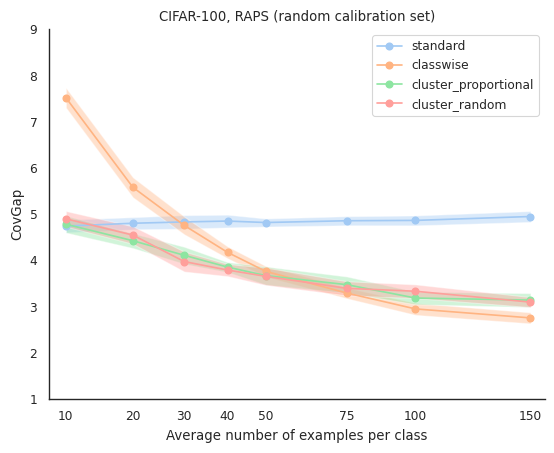

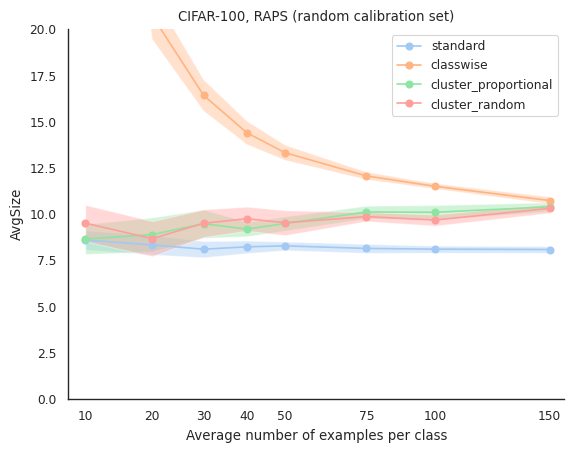

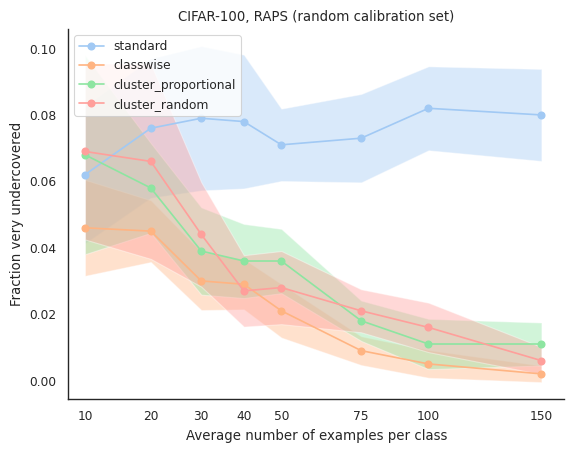

.cache/paper/varying_n/places365/random_calset/n_totalcal=10/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=20/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=30/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=40/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=50/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=75/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=100/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=150/score=softmax
Number of seeds found: 10


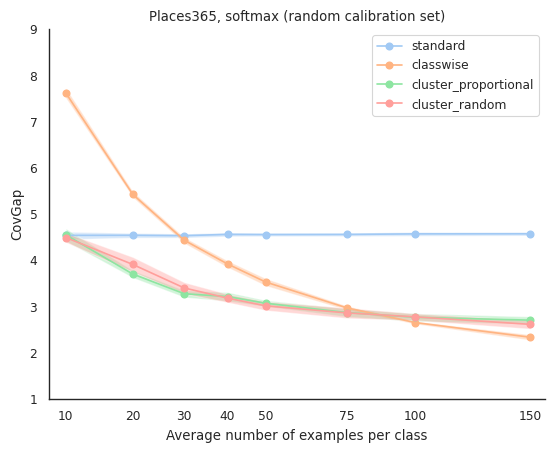

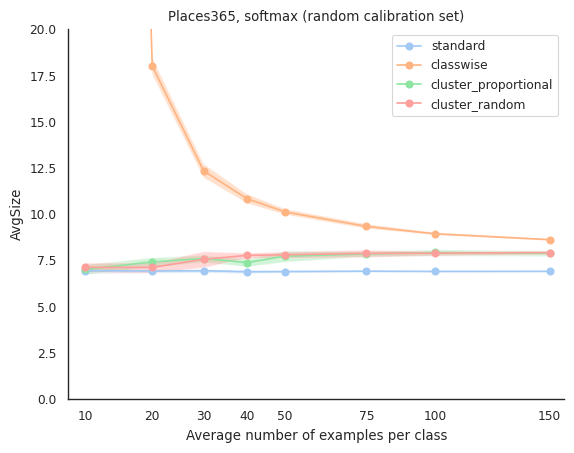

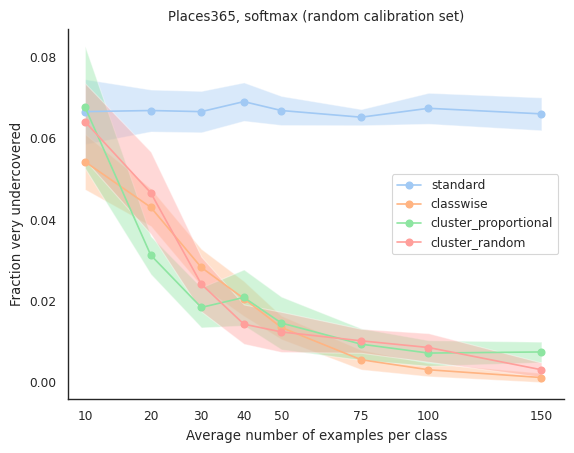

.cache/paper/varying_n/places365/random_calset/n_totalcal=10/score=APS
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=20/score=APS
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=30/score=APS
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=40/score=APS
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=50/score=APS
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=75/score=APS
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=100/score=APS
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=150/score=APS
Number of seeds found: 10


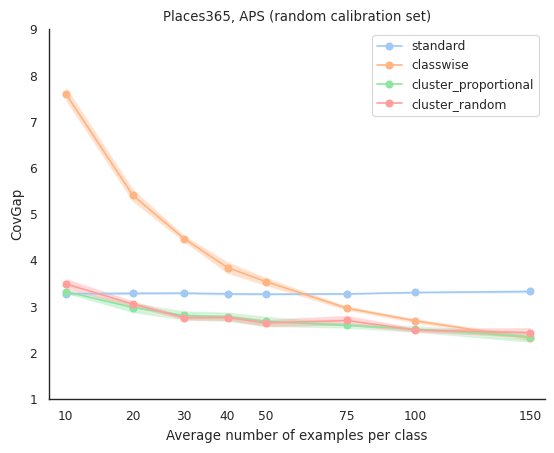

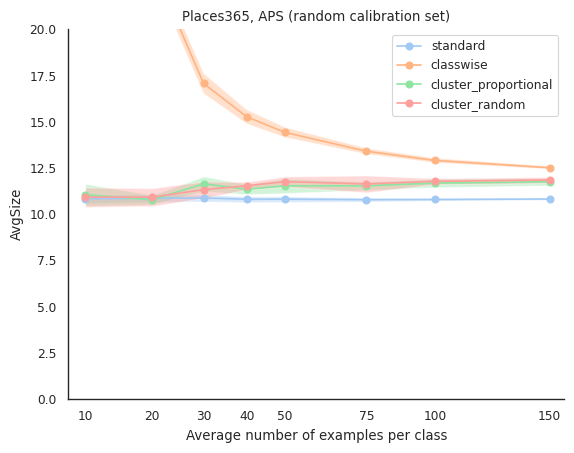

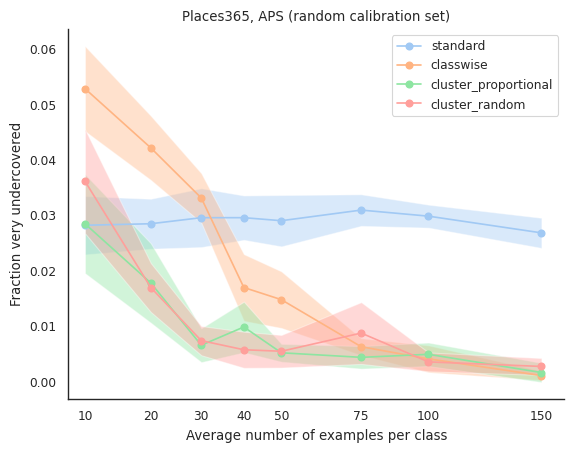

.cache/paper/varying_n/places365/random_calset/n_totalcal=10/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=20/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=30/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=40/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=50/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=75/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=100/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/places365/random_calset/n_totalcal=150/score=RAPS
Number of seeds found: 10


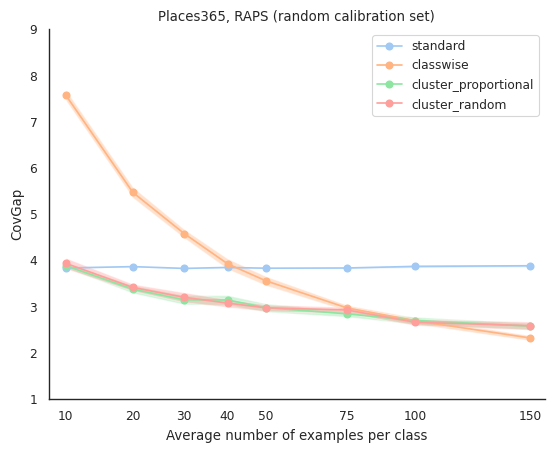

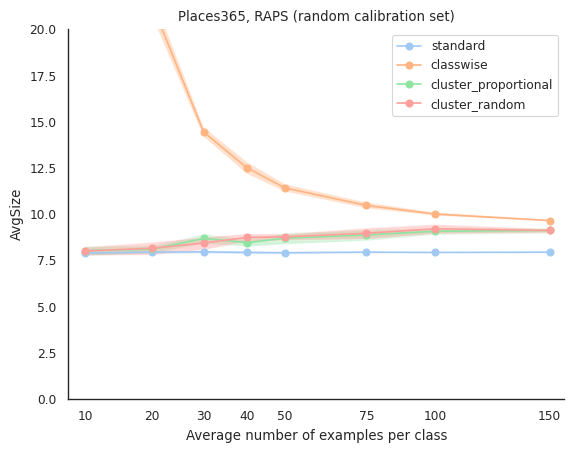

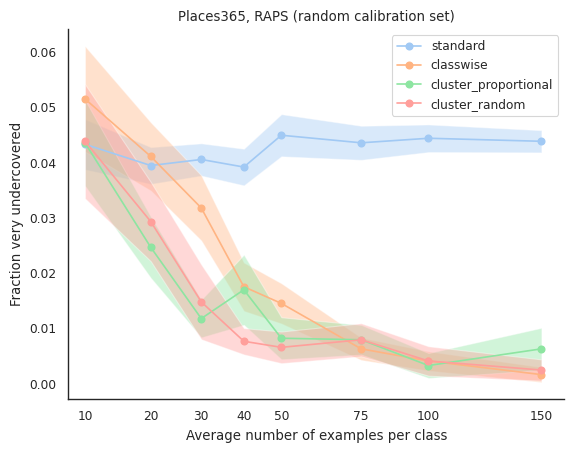

.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=10/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=20/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=30/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=40/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=50/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=75/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=100/score=softmax
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=150/score=softmax
Number of seeds found: 10


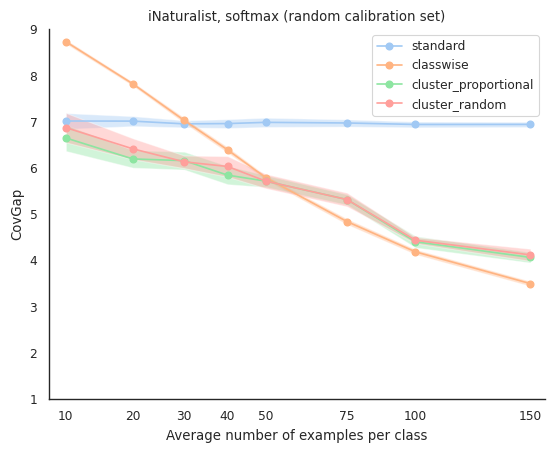

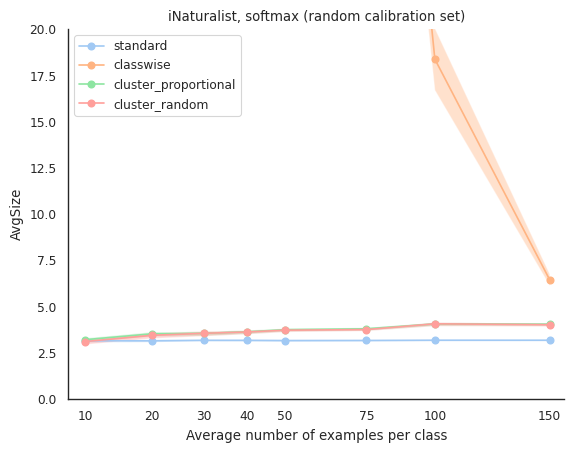

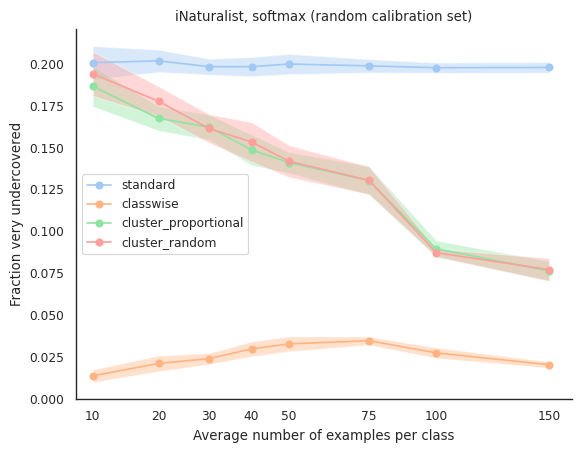

.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=10/score=APS
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=20/score=APS
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=30/score=APS
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=40/score=APS
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=50/score=APS
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=75/score=APS
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=100/score=APS
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=150/score=APS
Number of seeds found: 10


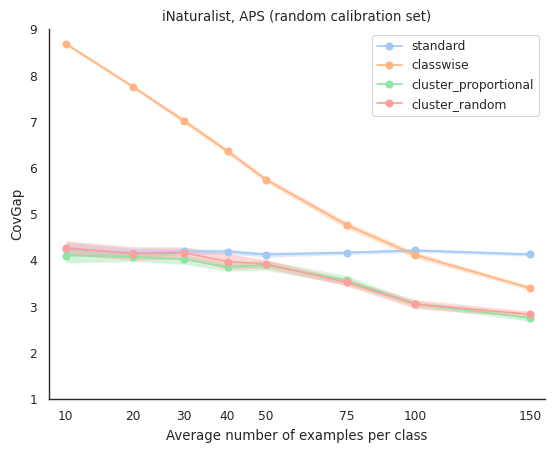

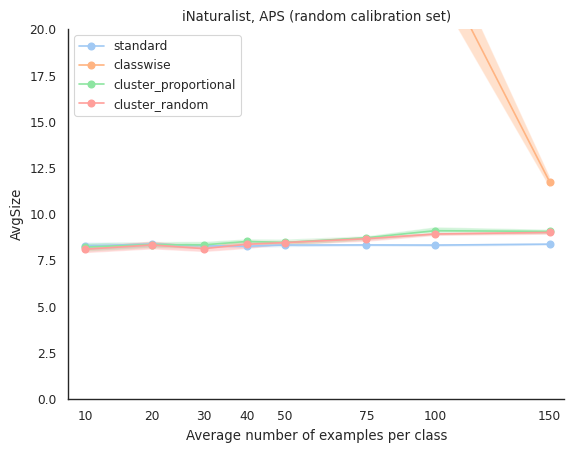

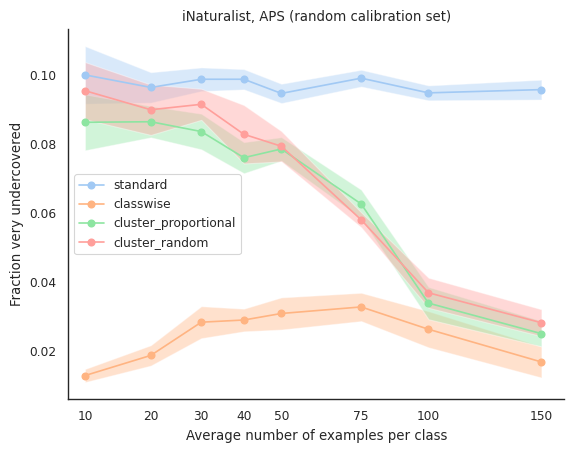

.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=10/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=20/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=30/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=40/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=50/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=75/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=100/score=RAPS
Number of seeds found: 10
.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=150/score=RAPS
Number of seeds found: 10


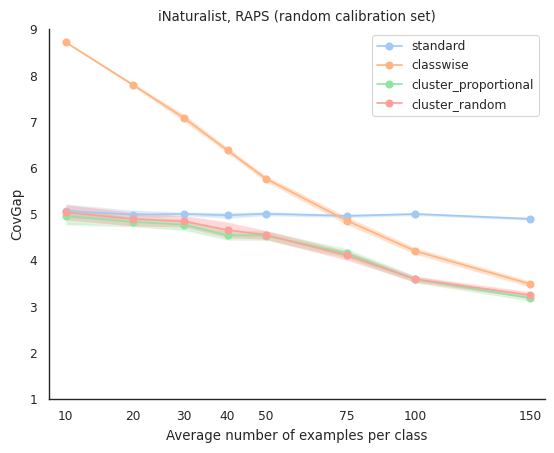

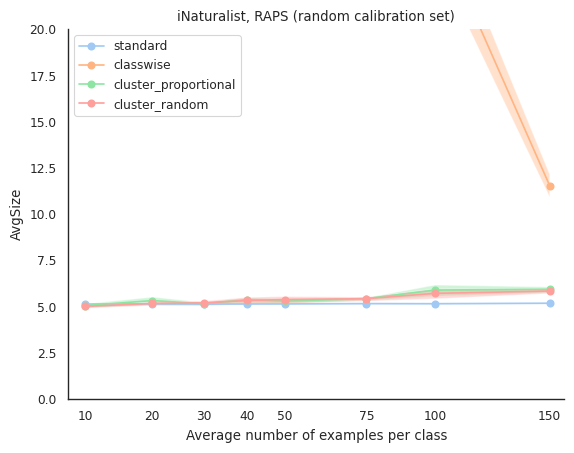

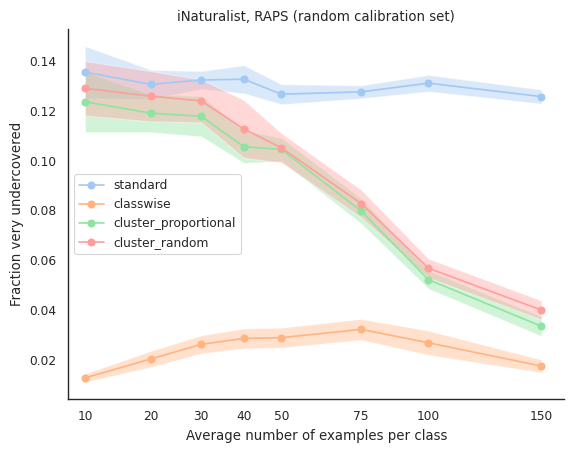

In [8]:
# dataset = 'imagenet'
# score_function = 'softmax'

dataset_list = ['imagenet', 'cifar-100', 'places365', 'inaturalist']
# dataset_list = ['imagenet', 'places365', 'inaturalist']
# score_function_list = ['softmax']
score_function_list = ['softmax', 'APS', 'RAPS']

for dataset in dataset_list:
    for score_function in score_function_list:
        make_varying_n_plot(dataset, score_function, n_list=n_list, cal_sampling=cal_sampling,
                            metric_list=metric_list, method_list=method_list)

# Final plots

In [9]:
method_to_name = {'standard': 'Standard', 'classwise': 'Classwise',
               'cluster_proportional': 'Clustered'}

metric_to_name = {'class_cov_gap': 'CovGap', 'avg_set_size': 'AvgSize', 'very_undercovered': 'Fraction very undercovered'}     

dataset_to_name = {'imagenet': 'ImageNet', 'cifar-100': 'CIFAR-100', 
                       'places365': 'Places365', 'inaturalist': 'iNaturalist'}

In [74]:
def get_metric_df(dataset, cal_sampling, metric, 
                  score_function,
                  method_list = ['standard', 'classwise', 'cluster_proportional'],
                  n_list = [10, 20, 30, 40, 50, 75, 100, 150],
                  save_folder='.cache/paper/varying_n'):
    
    aggregated_results = initialize_dict(metric_list, method_list)

    for n_totalcal in n_list:

        curr_folder = f'{save_folder}/{dataset}/{cal_sampling}_calset/n_totalcal={n_totalcal}/score={score_function}'

        df = average_results_across_seeds(curr_folder, print_results=False, display_table=False, methods=method_list, max_seeds=10)

        for method in method_list:

            for suffix in ['mean', 'se']: # Extract mean and SE

                aggregated_results[f'{metric}_{suffix}'][method].append(df[f'{metric}_{suffix}'][df['method']==method].values[0])
  
    return aggregated_results

def make_line_plot(aggregated_results, ax, 
                        n_list = [10, 20, 30, 40, 50, 75, 100, 150],
                        metric_to_name = {'class_cov_gap': 'CovGap', 'avg_set_size': 'AvgSize', 'very_undercovered': 'Fraction very undercovered'},
                        method_list = ['standard', 'classwise', 'cluster_proportional'],
                        dataset_to_name = {'imagenet': 'ImageNet', 'cifar-100': 'CIFAR-100', 
                       'places365': 'Places365', 'inaturalist': 'iNaturalist'}):

    print(f'{dataset_to_name[dataset]}, {score_function} ({cal_sampling} calibration set)')

    for method in method_list:
        x = n_list
        y = np.array(aggregated_results[f'{metric}_mean'][method])
        se = np.array(aggregated_results[f'{metric}_se'][method])
        ax.plot(x, y, '-o', label=method_to_name[method], alpha=1)
        # Add 95% error bars
        ax.fill_between(x, y-1.96*se, y+1.96*se, alpha=0.4)

        ax.set_xlabel('$n_{avg}$', fontsize=FONT_SIZE)
#     ax.set_xlabel('Average number of examples per class')
#     ax.set_ylabel(metric_to_name[metric])
#     ax.legend()

    ax.set_xscale('squareroot')
    ax.set_xlim(left=8)
    
    if metric == 'class_cov_gap':
        ax.set_ylim(1,9)
    if metric == 'avg_set_size':
        ax.set_ylim(0,50)

    ax.set_xticks(n_list)
    ax.tick_params(labelsize=FONT_SIZE-2) # Adjust tick label font size


### ImageNet softmax + APS plots

Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
ImageNet, APS (random calibration set)
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
ImageNet, RAPS (random calibration set)
Saved plot to /home/tding/code/class-conditional-conformal/figs/imagenet_randomcalset_combined.pdf


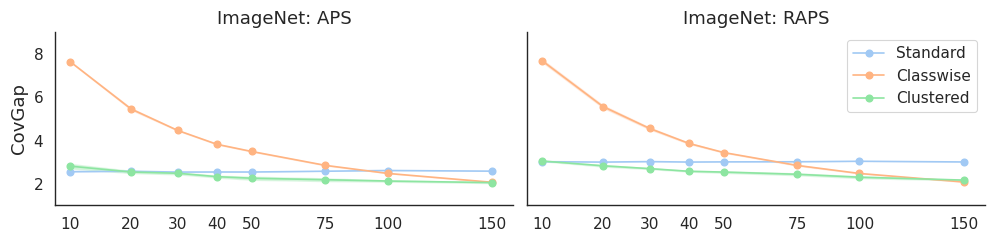

In [65]:
FONT_SIZE = 13

metric = 'class_cov_gap' 
fig_folder = '/home/tding/code/class-conditional-conformal/figs/'

dataset = 'imagenet'
cal_sampling = 'random'

# Side-by-side plots
ncols = 2
fig, axs = plt.subplots(1,ncols, 
                        gridspec_kw={'wspace':0.03},
                        figsize=(12, 2.25)) 

# for i, score_function in enumerate(['softmax', 'APS']):
score_function_list = ['APS', 'RAPS']
for i, score_function in enumerate(score_function_list):
    # Get data
    aggregated_results = get_metric_df(dataset, cal_sampling, metric, score_function)

    # Plot
    make_line_plot(aggregated_results, axs[i])
    
#     save_to = os.path.join(fig_folder, f'{dataset}_{cal_sampling}calset_{score_function}.pdf')
   
# Remove yticks for all but left-most axis
for i in range(1, ncols):
    axs[i].set_yticks([])
 
axs[0].set_ylabel(metric_to_name[metric], fontsize=FONT_SIZE)
axs[0].set_title(f'ImageNet: {score_function_list[0]}', fontsize=FONT_SIZE)
axs[1].set_title(f'ImageNet: {score_function_list[1]}', fontsize=FONT_SIZE)
axs[-1].legend(fontsize=FONT_SIZE-2) # Only show legend on right-most plot


    
save_to = os.path.join(fig_folder, f'{dataset}_{cal_sampling}calset_combined.pdf')
print(f'Saved plot to {save_to}')
plt.savefig(save_to, bbox_inches='tight')

plt.show()

### softmax and APS plots for remaining datasets

Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
CIFAR-100, APS (random calibration set)
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Places365, APS (random calibration set)
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
iNaturalist, APS (random calibration set)
Saved figure to /home/tding/code/class-conditional-conformal/figs/last3datasets_randomcalset_APS.pdf


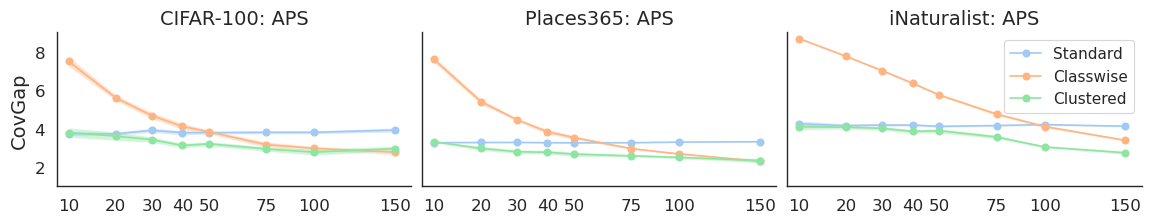

Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
CIFAR-100, RAPS (random calibration set)
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Places365, RAPS (random calibration set)
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
iNaturalist, RAPS (random calibration set)
Saved figure to /home/tding/code/class-conditional-conformal/figs/last3datasets_randomcalset_RAPS.pdf


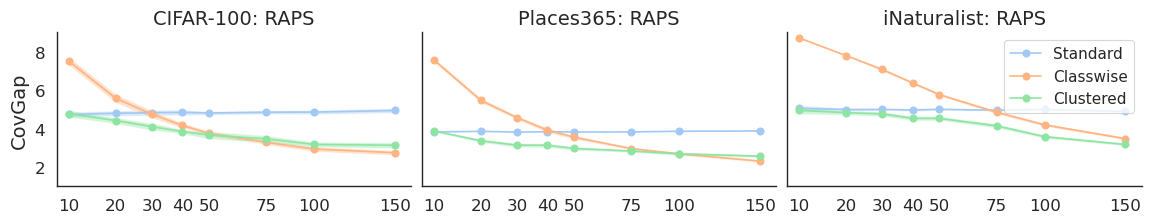

In [66]:
FONT_SIZE = 14

metric = 'class_cov_gap' 
fig_folder = '/home/tding/code/class-conditional-conformal/figs/'

cal_sampling = 'random'
dataset_list = ['cifar-100', 'places365', 'inaturalist']

# ==== PLOT 1a and 1b ==== 
score_function_list = ['APS', 'RAPS']
for score_function in score_function_list:
    
    ncols = len(dataset_list)
    fig, axs = plt.subplots(1,ncols, 
                        gridspec_kw={'wspace':0.03},
                        figsize=(14, 2)) 
    
    for i, dataset in enumerate(dataset_list):

        aggregated_results = get_metric_df(dataset, cal_sampling, metric, score_function)

        # Plot
        make_line_plot(aggregated_results, axs[i])
        axs[i].set_title(f'{dataset_to_name[dataset]}: {score_function}', fontsize=FONT_SIZE)
    
    # Remove yticks for all but left-most axis
    for i in range(1, ncols):
        axs[i].set_yticks([])

    axs[0].set_ylabel(metric_to_name[metric], fontsize=FONT_SIZE)
    axs[-1].legend(fontsize=FONT_SIZE-3) # Only show legend on right-most plot
    
    save_to = os.path.join(fig_folder, f'last3datasets_{cal_sampling}calset_{score_function}.pdf')
    plt.savefig(save_to, bbox_inches='tight')
    print(f'Saved figure to {save_to}')
    
    plt.show()

## softmax + APS for all datasets (4x2 grid)

Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
ImageNet, softmax (random calibration set)
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
ImageNet, APS (random calibration set)
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
CIFAR-100, softmax (random calibration set)
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
Number of seeds found: 10
CIFAR-100, APS (random calibration set)
Nu

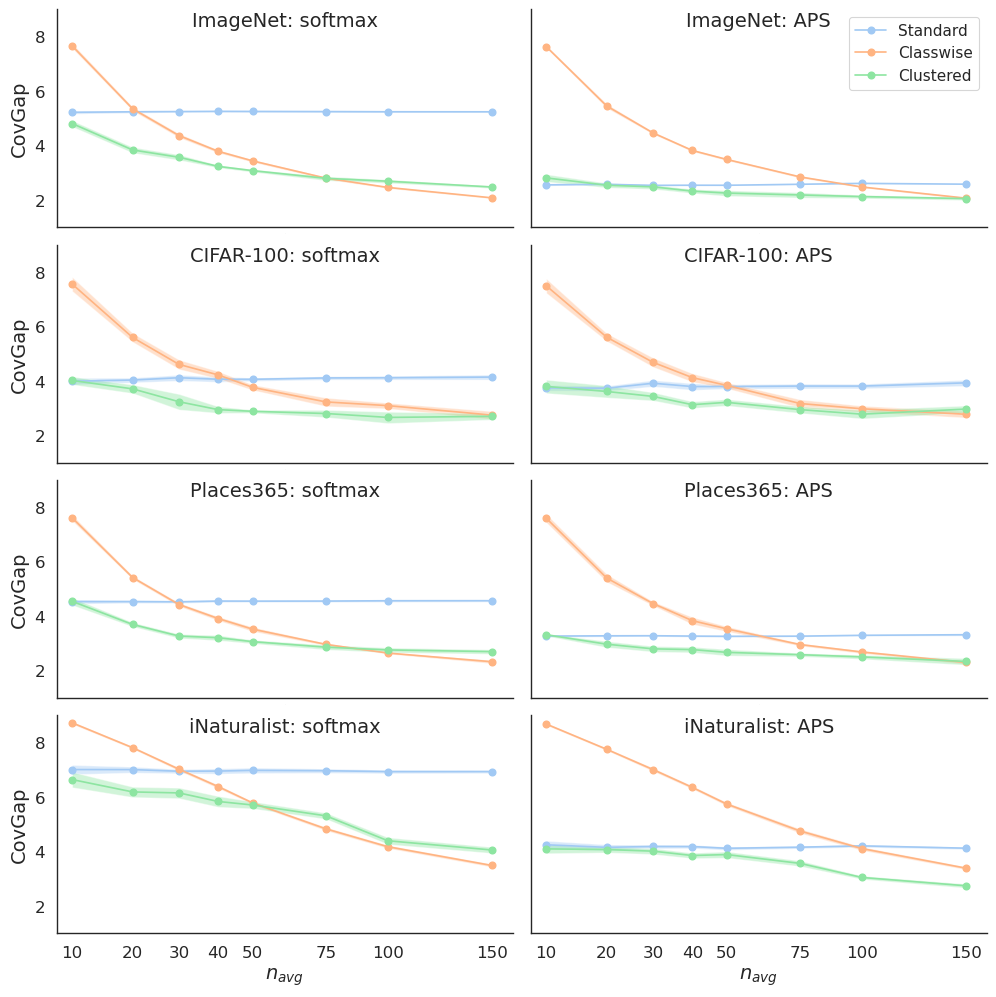

In [86]:
FONT_SIZE = 14
fig_height = 12

metric = 'class_cov_gap' 
fig_folder = '/home/tding/code/class-conditional-conformal/figs/'

cal_sampling = 'random'
dataset_list = ['imagenet', 'cifar-100', 'places365', 'inaturalist']
score_function_list = ['softmax','APS']

nrows = len(dataset_list)
ncols = len(score_function_list)

fig, axs = plt.subplots(nrows,ncols, 
            gridspec_kw={'wspace':0.04, # Horizontal space between subplots
                         'hspace': 0.08}, # Veritcal space between subplots
            figsize=(12, fig_height)) # Prev: (12,9)
    
for i, dataset in enumerate(dataset_list):    

    for j, score_function in enumerate(score_function_list):
        
        ax = axs[i][j]

        aggregated_results = get_metric_df(dataset, cal_sampling, metric, score_function)

        # Plot
        make_line_plot(aggregated_results, ax)
        ax.set_title(f'{dataset_to_name[dataset]}: {score_function}', 
                     fontsize=FONT_SIZE,
                     pad=-(FONT_SIZE)+2) # Shift plot title down
        
        
#         Remove y-ticks except for bottom plots
        if i < nrows - 1:
            ax.set_xticks([])
            ax.set_xlabel('.', fontsize=1) # hacky fix

        # Remove y-ticks and label except for left-most plots
        if j > 0:
            ax.set_yticks([])
            
       
        # Set y-label
        if j == 0:
            ax.set_ylabel(metric_to_name[metric], fontsize=FONT_SIZE)


#         axs[0].set_ylabel(metric_to_name[metric], fontsize=FONT_SIZE)
axs[0, ncols-1].legend(fontsize=FONT_SIZE-3) # Only show legend on right-most plot

save_to = os.path.join(fig_folder, f'alldatasets_{cal_sampling}calset_height{fig_height}.pdf')
plt.savefig(save_to, bbox_inches='tight')
print(f'Saved figure to {save_to}')

plt.show()